In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# number of grid points
# defines the fidelity of the sim
# memory usage is O(Nm * Nt) < 1e9!
Nm = 10000
Nt = 10000

# time bounds and derived timestep
years2sec = 3.154e7
tmax = 6e9 * years2sec  # s
tmin = 1e8 * years2sec  # s
h = (tmax - tmin) / Nt

# spatial bounds and derived space step.
rmax = 6370e3  # m
rmin = 3475e3  # m
m = (rmax - rmin) / Nm
rv = list(np.linspace(rmin, rmax, num=Nm, endpoint=True))

# temperatures at extremes.
# FIXME: make Tmantle constant-flux condition!
Tsurface = 300
Tcmb = 2850  # Wagner actually uses constant T here (not sure what is most appropriate)

In [3]:
# constants
# first trying to reproduce Wagner+ 2019 GJI
k = 4  # W m-1 K-1
Cp = 1190  # J kg-1 K-1
alpha = 3e-5  # K-1
kappa = 9e-7  # m2 s-1
eta = 1e20  # Pa s, for now
rho = 4500  # kg m-3
g = 10  # m s-2
H = 1e-12  # W kg-1, TODO: time-dependent, precomputed heating rate

gamma = alpha / Cp * g  # adiabatic temperature gradient

In [113]:
def mixing_length(r, rmin=rmin, rmax=rmax, a=0.4109, b=0.5537, verbose=False):  # a and b are tunable parameters, from Wagner+ 2019
    h = r - rmin  # height above CMB
    D = rmax - rmin  # total thickness including non-convecting
    h_break = (D / 2) * b
    
    if h <= h_break:
        l = a * h / b
    if h > h_break:
        l = a * (D - h) / (2 - b)
    if l == 0:
        return 10
    else:
        return l


# def l(z):
#     # calibration parameters
#     alpha_mlt = 1
#     beta_mlt = 1
#     r = (z - zmin) / (zmax - zmin)
#     if r < beta_mlt/2:
#         return r * (zmax - zmin)
#     else:
#         return r * (zmin - zmax) + (zmax-zmin)

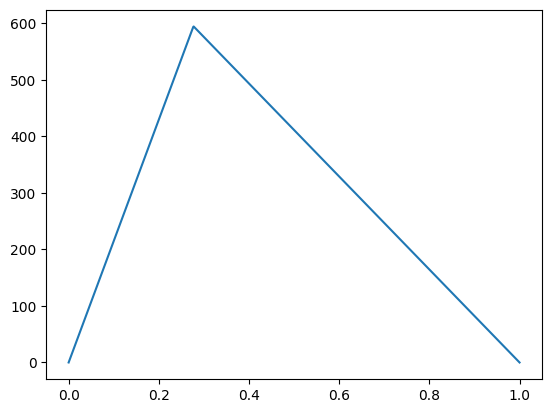

In [114]:
plt.plot([(r - rmin)/(rmax-rmin) for r in rv], [mixing_length(r)*1e-3 for r in rv])

In [115]:
U = []

def initial(z):
    return (Tsurface-Tcmb) / Nm * z + Tcmb
#     m = (Tsurface - Tcmb)/(zmax - zmin)
#     b = Tsurface - m*zmax
#     return m*z + b

U.append([initial(z) for z in range(Nm)])
# U.append([initial(z) for z in zv])

print(len(U))
print(len(U[0]))

1
1000


In [148]:
def build_initial(rv, d_tbl, dT_tbl, D=rmax-rmin):
    print('D', D*1e-3)
    U = [0] * Nm
    U[-1] = Tsurface
    first = True
    
    for ii in range(Nm-2, 0, -1):
        if rmax - rv[ii] < d_tbl:
            # linear (conductive)
            gr = -(dT_tbl)/(d_tbl)
#             print(rv[ii]*1e-3, 'height from top', (rmax - rv[ii])*1e-3, 'in tbl')
        else:
            if first:
                T_tbl = U[ii]
                print('T_tbl', U[ii + 1])
                first = False
            # also linear??
            gr = (Tsurface - dT_tbl - Tcmb) / (rmax - d_tbl - rmin)
        U[ii] = U[ii + 1] - gr * m
        
    U[0] = Tcmb
    return U

U = []
U.append(build_initial(rv, d_tbl=100e3, dT_tbl=1700-300, D=rmax-rmin))

D 2895.0
T_tbl 1698.285000000018


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000,)

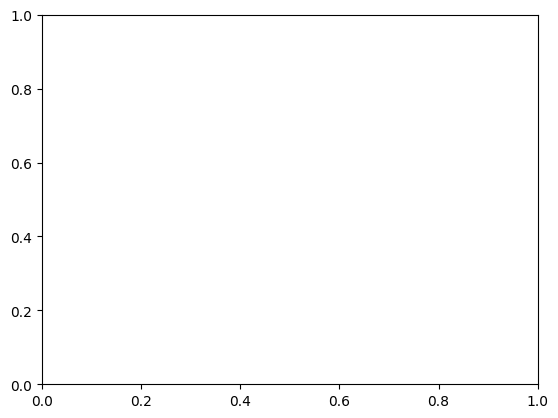

In [149]:
plt.plot(U[0], r_km)

In [78]:
# def update(U, z, H):
#     if z == 0:
#         return Tcmb
#     elif z == Nm-1:
#         return Tsurface
#     else:
#         l = mixing_length(z, zmax - zmin, zmin)
#         chi = (rho**2 * Cp * alpha * g) / (18 * eta) * l ** 4 # FIXME: need l!
        
# #         return U[z] + (h/(rho*Cp)) * (k + 2*chi*mixing_length(z, zmax-zmin, zmin)**4*((U[z+1]-U[z-1])/m) - gamma) * (U[z+1]-2*U[z]+U[z-1])/m**2 + (h/(rho*Cp)*H)
#         return U[z] + (h/(rho*Cp)) * (k - 2*chi*((U[z+1]-U[z-1])/m) - gamma) * (U[z+1]-2*U[z]+U[z-1])/m**2 + (h/(rho*Cp)*H)


In [117]:
# assume l and chi are t-independent
X = [(rho**2 * Cp * alpha * g) / (18 * eta) * mixing_length(r) ** 4 for r in rv] 

def update(U, z, H, return_param=None):  # z is index (not height in m)
    if z == 0:
        return Tcmb
    elif z == Nm - 1:
        return Tsurface
    else:
        # recalculate z,T-dependent parameters
        
        # discretized derivatives in z
        dTdz = (U[z+1] - U[z-1]) / (2*m)
        d2Tdz2 = (U[z+1] - 2*U[z] + U[z-1]) / m**2
        dXdz = (X[z+1] - X[z-1]) / (2*m)
        dGdz = 0
        
        # get individual terms
        cond_part = k * d2Tdz2
        
        if abs(gamma) >= abs(dTdz):
            conv_part = 0
        else:
            conv_part = -dXdz * (dTdz**2 - 2*gamma*dTdz + gamma**2) - X[z] * (2*dTdz*d2Tdz2 - 2*dGdz*dTdz - 2*gamma*d2Tdz2 + 2*gamma*dGdz)
        
        if return_param == None:
            return (cond_part + conv_part + rho*H) * (h/(rho*Cp)) + U[z]
        else:
            return eval(return_param)

In [118]:
# run

U = []
Fcond = []
Fconv = []
U.append([initial(z) for z in range(Nm)])

print(len(U))
print(len(U[0]))

# for i in range(1, Nt):
for i in range(1, 3):
    print(i)
    Fcond.append([update(U[-1], z, H, return_param='cond_part') * m for z in range(Nm)])
    Fconv.append([update(U[-1], z, H, return_param='conv_part') * m for z in range(Nm)])
    
    
    
    U.append([update(U[-1], z, H) for z in range(Nm)])
#     print(U[-1])
    
      

1
1000
1
2


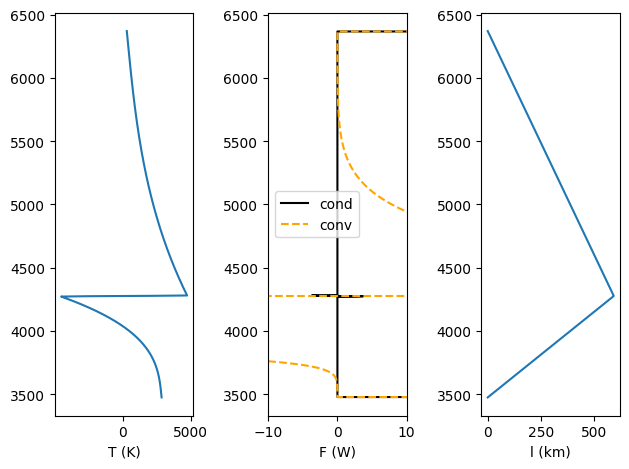

In [119]:
fig, axes = plt.subplots(1, 3)
r_km = [r * 1e-3 for r in rv]

axes[0].plot(U[1], r_km)
axes[0].set_xlabel('T (K)')

axes[1].plot(Fcond[1], r_km, c='k', label='cond')
axes[1].plot(Fconv[1], r_km, c='orange', ls='--', label='conv')
axes[1].legend()
axes[1].set_xlim(-10, 10)
axes[1].set_xlabel('F (W)')

axes[2].plot([mixing_length(r) * 1e-3 for r in rv], r_km)
axes[2].set_xlabel('l (km)')

plt.tight_layout()


    

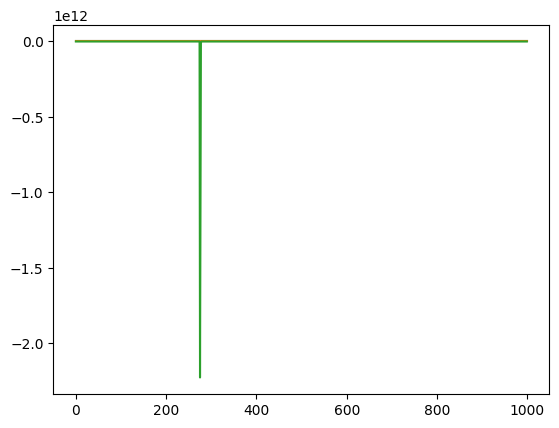

In [67]:
plt.plot([r * 1e-3 for r in rv], U[0])

In [57]:
print(U[-1])                                   

[2850, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan